# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="images/pic1.png"/>

Then you will want to run the above command:

<img src="images/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import datetime
from imblearn.over_sampling import RandomOverSampler
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time
import xgboost as xgb
from xgboost import XGBClassifier

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

portfolio_tmp = portfolio.copy()


# 1. EDA
## EDA on the transcript dataframe

In [3]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [4]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [5]:
transcript.groupby("event").count()

,person,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


## EDA on the profile dataframe

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [8]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

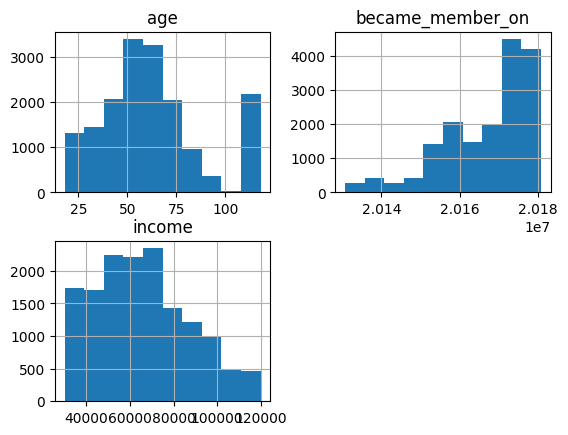

In [9]:
profile.hist();

- One can see that the age variable have people that are 118 years old. I assume that this is very rare and those customers have nan values for the other variables. So dropping all the nans.

In [10]:
profile = profile.dropna()
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

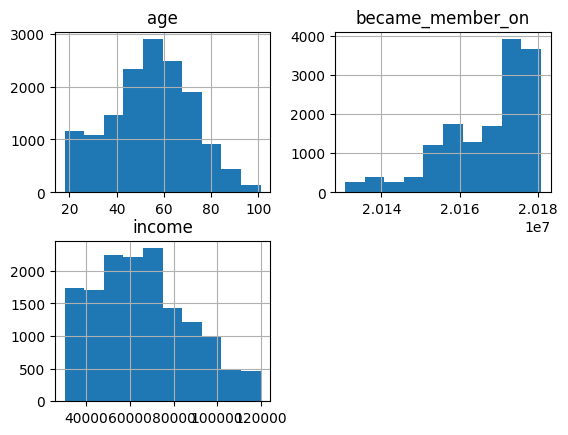

In [11]:
profile.hist();

## EDA on portfolio Dataframe

In [12]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [13]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [14]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

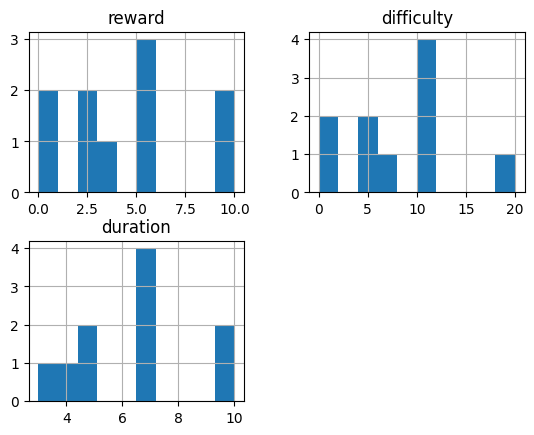

In [15]:
portfolio.hist();

# 2.0 Data Engineering
## 2.1 Transcript

In [16]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [17]:
# filtering to users that are in the profile dataframe because we can not train without those users.
transcript_new = transcript[transcript['person'].isin(profile['id'])]

In [18]:
transcript_new['offer_id'] = transcript_new['value'].apply(lambda val: val.get('offer_id', val.get('offer id', np.nan)))

/tmp/ipykernel_1201868/2209279805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript_new['offer_id'] = transcript_new['value'].apply(lambda val: val.get('offer_id', val.get('offer id', np.nan)))


In [19]:
transcript_new

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
...,...,...,...,...,...
306527,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,NaN


## 2.2 Profile

In [20]:
profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [21]:
def profile_engineering(dataframe):
    """
    Performs feature engineering on the input dataframe.

    This function processes the 'became_member_on' column to extract the year and weekday of membership,
    and converts categorical variables into dummy/indicator variables.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the profile data.

    Returns:
    pd.DataFrame: The dataframe after feature engineering, with new features and dummy variables.

    The function performs the following steps:
    1. Converts the 'became_member_on' column to datetime format.
    2. Extracts the year from the 'became_member_on' column and creates a new 'year' column.
    3. Extracts the weekday from the 'became_member_on' column and creates a new 'weekday_membership' column.
    4. Converts categorical variables ('gender' and 'year') into dummy/indicator variables.
    5. Drops the original 'became_member_on' column.
    """
    dataframe['became_member_on'] = pd.to_datetime(dataframe['became_member_on'], format='%Y%m%d')
    dataframe['year'] = dataframe['became_member_on'].dt.year.astype("int")
    dataframe['weekday_membership'] = dataframe['became_member_on'].dt.weekday
    dataframe = pd.get_dummies(dataframe, prefix=['gender', 'became_member_on'], columns=['gender', 'year'], dtype=int).drop('became_member_on', axis=1)
    
    return dataframe
    
profile_after_engineered = profile_engineering(profile)
profile_after_engineered.head()

,age,id,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,5,1,0,0,0,0,0,0,1,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,1,0,0,0,0,0,0,1,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,3,0,1,0,0,0,0,0,0,1
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,4,0,1,0,0,0,0,0,0,1
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,5,0,1,0,0,0,0,0,1,0


## 2.3 Portfolio

In [22]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [23]:
def transform_channel_values(channels):
    """
    Transform a list of channel names into a list of binary values indicating the presence of each channel.

    This function takes a list of channel names and returns a list of binary values (0 or 1) for each
    channel in the predefined list of all possible channels ('email', 'mobile', 'social', 'web').
    A value of 1 indicates the presence of the channel in the input list, while 0 indicates its absence.

    Args:
        channels (list): A list of channel names (strings).

    Returns:
        list: A list of binary values indicating the presence (1) or absence (0) of each channel.
    """
    channels_booleans = []
    channel_all_options = ['email', 'mobile', 'social', 'web']
    for channel in channel_all_options:
        if channel in channels:
            channels_booleans.append(1)
        else:
            channels_booleans.append(0)
    return channels_booleans

def portfolio_engineering(dataframe):
    """
    Performs data preprocessing and feature engineering on the input DataFrame for portfolio analysis.

    This function processes the input DataFrame by renaming columns, transforming channel values,
    converting duration to hours, and creating dummy variables for categorical features.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame containing portfolio data.

    Returns:
    pd.DataFrame: The DataFrame after preprocessing and feature engineering.

    The function performs the following steps:
    1. Renames the 'id' column to 'offer_id'.
    2. Creates a copy of the DataFrame to avoid modifying the original.
    3. Transforms the 'channels' column into separate columns for each channel option ('email', 'mobile', 'social', 'web').
    4. Drops the original 'channels' column.
    5. Converts the 'duration' column from days to hours and renames it to 'duration_hours'.
    6. Drops the original 'duration' column.
    7. Creates dummy variables for the 'offer_type' column.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    dataframe.rename(columns={'id': 'offer_id'}, inplace=True)
    dataframe = dataframe.copy()
    
    channel_all_options = ['email', 'mobile', 'social', 'web']
    dataframe[channel_all_options] = dataframe['channels'].apply(transform_channel_values).apply(pd.Series)
    dataframe = dataframe.drop('channels', axis=1)
    
    dataframe['duration_hours'] = dataframe['duration'].apply(lambda val: val * 24)
    dataframe = dataframe.drop('duration', axis=1)
    dataframe = pd.get_dummies(dataframe, columns=['offer_type'], dtype=int)
    
    return dataframe

# Example usage
portfolio_after_engineer = portfolio_engineering(portfolio)

In [24]:
portfolio_after_engineer.head()

,reward,difficulty,offer_id,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,168,1,0,0
1,10,10,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120,1,0,0
2,0,0,3f207df678b143eea3cee63160fa8bed,1,1,0,1,96,0,0,1
3,5,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,168,1,0,0
4,5,20,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,240,0,1,0


# Merging dataframes

In [25]:
merged_transcript = transcript_new.merge(profile_after_engineered, left_on='person', right_on='id', how='left').drop('person', axis=1)
merged_transcript.head()

,event,value,time,offer_id,age,id,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,1,0,0,0,0,0,0,1,0
1,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,68,e2127556f4f64592b11af22de27a7932,70000.0,3,0,1,0,0,0,0,0,0,1
2,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,f19421c1d4aa40978ebb69ca19b0e20d,65,389bc3fa690240e798340f5a15918d5c,53000.0,4,0,1,0,0,0,0,0,0,1
3,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,5,0,1,0,0,0,0,0,1,0
4,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,61,aa4862eba776480b8bb9c68455b8c2e1,57000.0,0,1,0,0,0,0,0,0,1,0


In [26]:
df = merged_transcript.merge(portfolio_after_engineer, on='offer_id', how='left').sort_values(by=['id', 'time']).reset_index(drop=True)
df.head(10)

,event,value,time,offer_id,age,id,income,weekday_membership,gender_F,gender_M,...,reward,difficulty,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational
0,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,0.0,0.0,1.0
1,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,5a8bc65990b245e5a138643cd4eb9837,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,0.0,0.0,1.0
2,transaction,{'amount': 22.16},228,NaN,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,3f207df678b143eea3cee63160fa8bed,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,0.0,0.0,1.0
4,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,3f207df678b143eea3cee63160fa8bed,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,0.0,0.0,1.0
5,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,f19421c1d4aa40978ebb69ca19b0e20d,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,5.0,5.0,1.0,1.0,1.0,1.0,120.0,1.0,0.0,0.0
6,transaction,{'amount': 8.57},414,NaN,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414,f19421c1d4aa40978ebb69ca19b0e20d,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,5.0,5.0,1.0,1.0,1.0,1.0,120.0,1.0,0.0,0.0
8,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},456,f19421c1d4aa40978ebb69ca19b0e20d,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,5.0,5.0,1.0,1.0,1.0,1.0,120.0,1.0,0.0,0.0
9,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504,fafdcd668e3743c1bb461111dcafc2a4,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,2.0,10.0,1.0,1.0,1.0,1.0,240.0,0.0,1.0,0.0


We will have to treat the offers in two differents ways, depending on their type. For offers of type "informational", it is just an advertisement, so there is no "reward", nor a "difficulty". Also, for this type of offer, their is no "offer completed" event. 

Therefore, here are the steps necessary for the different offer types to be considered "successful": 

"BOGO" and "discount: 

    1. "offer received"
    2. "offer viewed"
    3. "offer completed"
    4. "transaction"
    
"informational":

    1. "offer received"
    2. "offer viewed"
    3. "transaction"
    
Let us investigate this further

In [27]:
transcript_new.merge(portfolio, on='offer_id').groupby(['offer_type','event'])[['time','difficulty', 'duration', 'reward']].sum()

time  difficulty  duration  reward
offer_type    event                                                 
bogo          offer completed  5976720      111125     91980  111125
              offer received   8830488      199065    159421  199065
              offer viewed     7790010      171345    128995  171345
discount      offer completed  6988410      191062    145469   49416
              offer received   8861376      313935    226782   80161
              offer viewed     6547176      187623    155093   49946
informational offer received   4427088           0     46557       0
              offer viewed     3340554           0     31567       0

In [28]:
df.head()

,event,value,time,offer_id,age,id,income,weekday_membership,gender_F,gender_M,...,reward,difficulty,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational
0,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,0.0,0.0,1.0
1,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,5a8bc65990b245e5a138643cd4eb9837,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,0.0,0.0,1.0
2,transaction,{'amount': 22.16},228,NaN,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,3f207df678b143eea3cee63160fa8bed,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,0.0,0.0,1.0
4,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,3f207df678b143eea3cee63160fa8bed,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,0.0,0.0,1.0


In [29]:
# Create a copy of the original DataFrame
new_df = df.copy()

# Extract all unique customer IDs from the 'id' column
customer_ids = list(new_df['id'].unique())

# Sort the DataFrame by 'time' and group by 'id'
groups = new_df.sort_values('time').groupby('id')

# Retrieve the group of data for the second customer in the customer_ids list
group2 = groups.get_group(customer_ids[1])

In [30]:
def is_offer_successfull(customer_df):
    """
    Checks if offers are successful for a given customer.

    Parameters:
    customer_df (DataFrame): A DataFrame containing customer offer data with columns such as 'event', 'time', 'duration_hours', and 'offer_type_informational'.

    Returns:
    dict: A dictionary where keys are row indices and values indicate whether the offer was successful (1) or not (0) for each corresponding row.

    The function iterates through each row in the customer DataFrame to determine if an offer was successful. An offer is considered successful if:
    - The 'offer received' event is followed by an 'offer viewed' event.
    - For informational offers, a 'transaction' event occurs before the deadline.
    - For other offers, either an 'offer completed' or 'transaction' event occurs before the deadline.

    The function updates a dictionary (`customer_successful_map`) with the success status for each row and its subsequent rows involved in the offer process.
    """
    completed_with_success = False
    
    customer_successful_map = {}
    
    for idx, row in customer_df.iterrows():
        successful = 0
        if row.event == 'offer received':
            deadline = row.time + row.duration_hours
            next_row = new_df.loc[idx + 1]
            if next_row.event == 'offer viewed':
                next_next_row  = new_df.loc[idx + 2]
                if next_next_row.time <= row.time + deadline:
                    if row.offer_type_informational == 1:
                        if next_next_row.event == 'transaction':
                            successful = 1
                    else:
                        if next_next_row.event == 'offer completed' or next_next_row.event == 'transaction':
                            successful = 1
                            completed_with_success = True
                            
        if idx not in customer_successful_map:
            customer_successful_map[idx], customer_successful_map[idx + 1], customer_successful_map[idx + 2] = successful, successful, successful
            if completed_with_success:
                 customer_successful_map[idx + 3] = successful
    return customer_successful_map

In [31]:
group2

,event,value,time,offer_id,age,id,income,weekday_membership,gender_F,gender_M,...,reward,difficulty,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational
20,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,3f207df678b143eea3cee63160fa8bed,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,0.0,0.0,1.0
21,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},6,3f207df678b143eea3cee63160fa8bed,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,0.0,0.0,1.0
22,transaction,{'amount': 13.49},132,NaN,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},168,2298d6c36e964ae4a3e7e9706d1fb8c2,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,3.0,7.0,1.0,1.0,1.0,1.0,168.0,0.0,1.0,0.0
24,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},186,2298d6c36e964ae4a3e7e9706d1fb8c2,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,3.0,7.0,1.0,1.0,1.0,1.0,168.0,0.0,1.0,0.0
26,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,252,2298d6c36e964ae4a3e7e9706d1fb8c2,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,3.0,7.0,1.0,1.0,1.0,1.0,168.0,0.0,1.0,0.0
25,transaction,{'amount': 11.93},252,NaN,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},336,5a8bc65990b245e5a138643cd4eb9837,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,0.0,0.0,1.0
28,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},354,5a8bc65990b245e5a138643cd4eb9837,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,0.0,0.0,1.0
29,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},408,0b1e1539f2cc45b7b9fa7c272da2e1d7,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,...,5.0,20.0,1.0,0.0,0.0,1.0,240.0,0.0,1.0,0.0


In [32]:
is_offer_successfull(group2)

{20: 0,
 21: 0,
 22: 0,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 0,
 36: 0,
 37: 0,
 38: 0}

In [33]:
# Initialize an empty dictionary to store the success status of offers
successful_map = {}

# Add a new column 'successful_offer' to the DataFrame and initialize with NaN values
new_df['successful_offer'] = np.nan

# Sort the DataFrame by 'time' and group by 'id'
grouped_users = new_df.sort_values('time').groupby('id')

# Iterate over each customer group
for customer, customer_df in grouped_users:
    # Check if offers are successful for the current customer
    customer_map = is_offer_successfull(customer_df)
    # Update the successful_map with the results for the current customer
    successful_map.update(customer_map)

# Fill the 'successful_offer' column with the values from successful_map
new_df['successful_offer'] = new_df['successful_offer'].fillna(successful_map)

In [34]:
new_df['successful_offer'].value_counts()

successful_offer
0.0    225707
1.0     47055
Name: count, dtype: int64

In [35]:
final_df = new_df.drop(['id', 'offer_id', 'value', 'time', 'event'], axis=1).dropna(axis=0).drop_duplicates(keep='first')

In [36]:
def save_df_to_csv(df, filepath):
    """
    Save a given DataFrame to a CSV file.

    Parameters:
    df (DataFrame): The DataFrame to be saved.
    filepath (str): The path (including the filename) where the CSV file will be saved.

    This function saves the provided DataFrame to a CSV file at the specified filepath. The index of the DataFrame is not included in the CSV file.
    """
    df.to_csv(path_or_buf=filepath, index=False)
    
save_df_to_csv(final_df, 'data/cleaned_data.csv')

# 3. Data Analysis

In [37]:
def get_analysis_df(df, portfolio):
    """
    Prepare a DataFrame for analysis by cleaning and merging with a portfolio DataFrame.

    Parameters:
    df (DataFrame): The original DataFrame containing offer data.
    portfolio (DataFrame): The portfolio DataFrame containing offer details.

    Returns:
    DataFrame: A cleaned and merged DataFrame ready for analysis.

    The function performs the following steps:
    1. Drops the 'value', 'time', and 'event' columns from the original DataFrame.
    2. Removes rows with any missing values.
    3. Drops duplicate rows, keeping the first occurrence.
    4. Merges the cleaned DataFrame with the portfolio DataFrame on the 'offer_id' column using an inner join.
    5. Drops the 'difficulty_x' and 'reward_x' columns from the merged DataFrame.
    6. Renames the 'difficulty_y' and 'reward_y' columns to 'difficulty' and 'reward', respectively.

    This results in a DataFrame that is cleaned, merged, and ready for further analysis.
    """
    df_analysis = df.drop(['value', 'time', 'event'], axis=1) \
        .dropna(axis=0) \
        .drop_duplicates(keep='first') \
        .merge(portfolio, on='offer_id', how='inner') \
        .drop(['difficulty_x', 'reward_x'], axis=1) \
        .rename(columns={'difficulty_y': 'difficulty', 'reward_y': 'reward'})
    return df_analysis

In [38]:
portfolio_tmp = portfolio_tmp.rename(columns={'id': 'offer_id'})
df_analysis = get_analysis_df(df=new_df, portfolio=portfolio_tmp)
df_analysis.head()

,offer_id,age,id,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,...,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational,successful_offer,reward,channels,difficulty,duration,offer_type
0,5a8bc65990b245e5a138643cd4eb9837,33,0009655768c64bdeb2e877511632db8f,72000.0,4,0,1,0,0,0,...,72.0,0.0,0.0,1.0,1.0,0,"[email, mobile, social]",0,3,informational
1,5a8bc65990b245e5a138643cd4eb9837,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,0,0,1,0,0,...,72.0,0.0,0.0,1.0,0.0,0,"[email, mobile, social]",0,3,informational
2,5a8bc65990b245e5a138643cd4eb9837,59,0020c2b971eb4e9188eac86d93036a77,90000.0,4,1,0,0,0,0,...,72.0,0.0,0.0,1.0,0.0,0,"[email, mobile, social]",0,3,informational
3,5a8bc65990b245e5a138643cd4eb9837,24,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,4,1,0,0,0,0,...,72.0,0.0,0.0,1.0,0.0,0,"[email, mobile, social]",0,3,informational
4,5a8bc65990b245e5a138643cd4eb9837,26,003d66b6608740288d6cc97a6903f4f0,73000.0,2,1,0,0,0,0,...,72.0,0.0,0.0,1.0,1.0,0,"[email, mobile, social]",0,3,informational


In [39]:
successful_offers = final_df[final_df['successful_offer'] == 1]
percentage_of_success = len(successful_offers) / len(final_df)

print("The percentage of success on all the different offers is {:.2f}%.".format(percentage_of_success * 100))

The percentage of success on all the different offers is 21.62%.


In [40]:
def plot_successful_projects_probabilities(df, attribute, attribute_title, x_axis_title=None, palette="viridis"):
    """
    Plot the probability of success of a project for a specified attribute.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    attribute (str): The attribute to group by and plot.
    attribute_title (str): The title for the attribute to be displayed on the plot.
    x_axis_title (str, optional): The title for the x-axis. Defaults to None.
    palette (str, optional): The color palette to use for the plot. Defaults to "viridis".

    This function creates a bar plot showing the probability of success for a specified attribute.
    The mean percentage of success is indicated by a dashed line.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    
    # Calculate the mean success rate for each attribute value
    s = df.groupby(attribute)['successful_offer'].mean()
    df_plot = pd.DataFrame({attribute: s.index, '% of success': s.values})
    
    # Create the bar plot
    p1 = sns.barplot(x=attribute, y='% of success', data=df_plot, palette=palette)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add a horizontal line for the mean percentage of success
    percentage_of_success = df['successful_offer'].mean()
    ax.axhline(y=percentage_of_success, color='black', linestyle='--')
    
    # Add text annotation for the mean percentage of success
    p1.text(0, percentage_of_success + 0.003, "Mean % of success", horizontalalignment='left', size='medium', color='black')
    
    # Set the title and labels for the plot
    ax.set_title(f'Probability of success by {attribute_title}', fontsize=20)
    if x_axis_title:
        ax.set_xlabel(x_axis_title.capitalize(), fontsize=15)
    else:
        ax.set_xlabel(attribute_title.capitalize(), fontsize=15)
    ax.set_ylabel("% of success", fontsize=15)
    
    plt.show()

In [41]:
save_df_to_csv(df_analysis, 'data/data_for_analysis.csv')

/tmp/ipykernel_1201868/1644501313.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p1 = sns.barplot(x=attribute, y='% of success', data=df_plot, palette=palette)


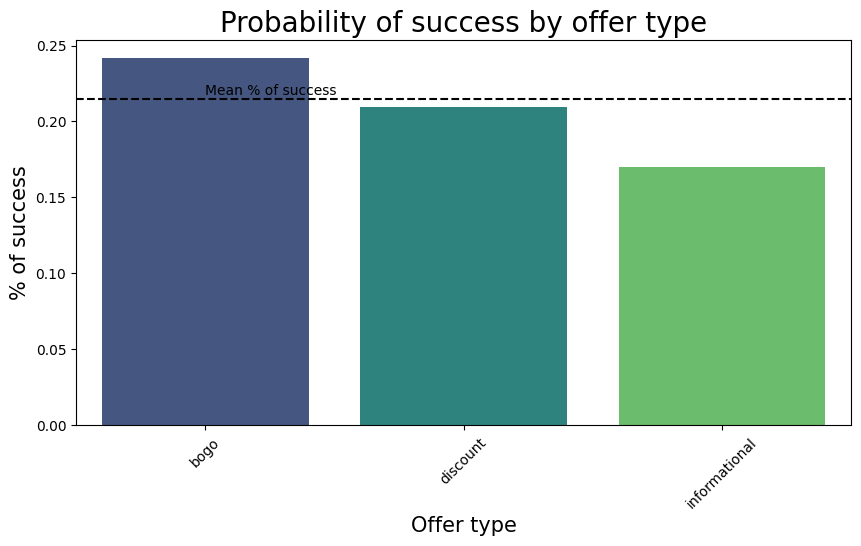

In [42]:
plot_successful_projects_probabilities(df=df_analysis, attribute='offer_type', attribute_title='offer type');

The graph above shows that "BOGO" (Buy One Get One Free) offers are the most successful. This result is expected, as such offers are highly attractive to customers who receive a free item. In contrast, "Discount" offers only provide a better price, making them less appealing. Lastly, "Informational" offers, which do not offer any reward to the customer, are the least successful, as anticipated.

In [43]:
def age_interval(age):
    """
    Categorize age into an interval.

    This function takes an age value and categorizes it into a predefined interval.

    Parameters:
    age (int): The age value to be categorized.

    Returns:
    str: The interval in which the age falls.

    Raises:
    ValueError: If the age value is not within the expected range.

    Example:
    >>> age_interval(25)
    '[20, 30)'

    The intervals are defined as follows:
    - '[0, 10)': Ages from 0 to 9
    - '[10, 20)': Ages from 10 to 19
    - '[20, 30)': Ages from 20 to 29
    - '[30, 40)': Ages from 30 to 39
    - '[40, 50)': Ages from 40 to 49
    - '[50, 60)': Ages from 50 to 59
    - '[60, 70)': Ages from 60 to 69
    - '[70+, ]': Ages 70 and above
    """
    if age < 10:
        interval = '[0, 10)'
    elif age >= 10 and age < 20:
        interval = '[10, 20)'
    elif age >= 20 and age < 30:
        interval = '[20, 30)'
    elif age >= 30 and age < 40:
        interval = '[30, 40)'
    elif age >= 40 and age < 50:
        interval = '[40, 50)'
    elif age >= 50 and age < 60:
        interval = '[50, 60)'
    elif age >= 60 and age < 70:
        interval = '[60, 70)'
    elif age >= 70:
        interval = '[70+, ]'
    else:
        raise ValueError(f"Unknown value for age: {age}")
    return interval

In [44]:
df_analysis['age_interval'] = df_analysis['age'].apply(age_interval)

/tmp/ipykernel_1201868/1644501313.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p1 = sns.barplot(x=attribute, y='% of success', data=df_plot, palette=palette)


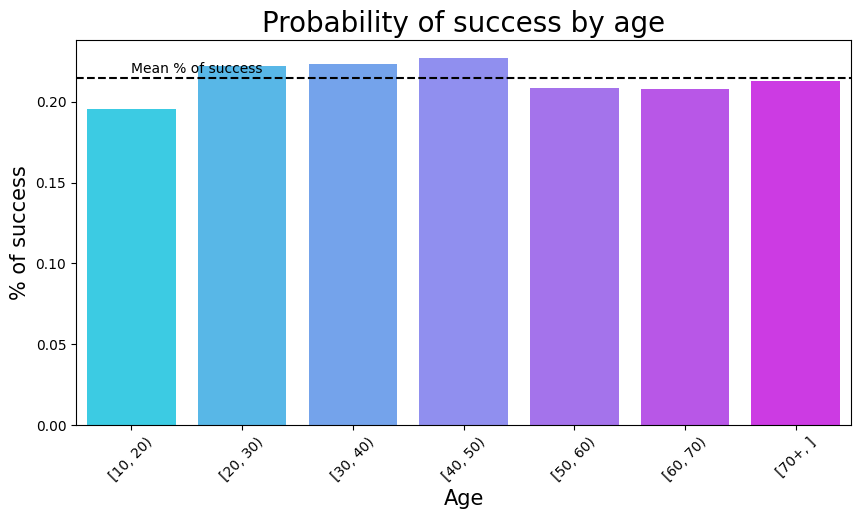

In [45]:
plot_successful_projects_probabilities(df=df_analysis, attribute='age_interval', attribute_title='age', palette = 'cool')

The results are quite intriguing. They suggest that both the younger and older generations are less influenced by various offer types. One interpretation could be that these customers purchase Starbucks products for specific reasons. For instance, older individuals might buy a product to relax at a coffee shop, while younger ones might want a drink to enjoy while shopping or to boost their energy before school. Consequently, these customers are likely to buy coffee regardless of any offers. Therefore, it might be strategic to limit offers, especially those providing discounts or free items, to these groups.

/tmp/ipykernel_1201868/1644501313.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p1 = sns.barplot(x=attribute, y='% of success', data=df_plot, palette=palette)


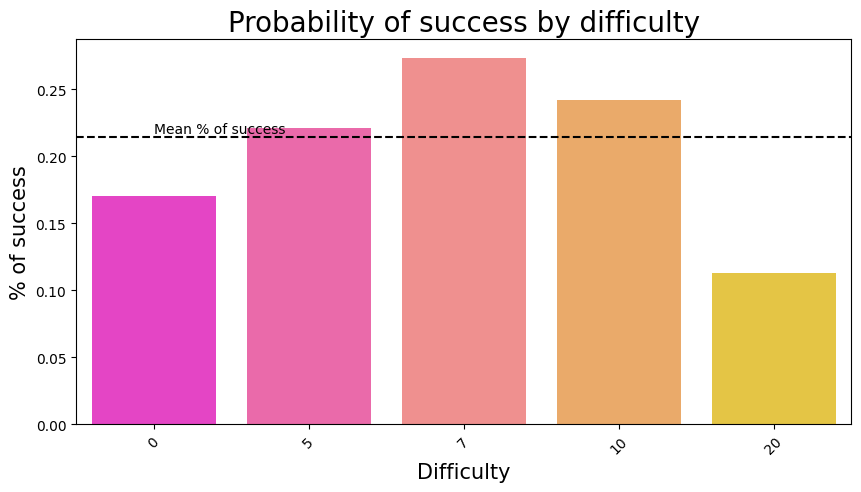

In [46]:
plot_successful_projects_probabilities(df=df_analysis, attribute='difficulty', attribute_title='difficulty', palette='spring')

The graph indicates that the difficulty level, or the amount a customer needs to spend to complete an offer, significantly impacts the likelihood of the offer being completed. Offers requiring a purchase of $20 or more are the least successful, likely because they only provide a reward of $5, making them less attractive to customers.

Offers with a difficulty level of "0" are informational and offer no reward, which aligns with their low success rate. The most successful difficulty level is "7," which offers a reward of $3, presenting a favorable balance between spending and reward for customers. The second most successful difficulty level is "10," offering rewards of either $10 or $2. The $10 reward corresponds to the "Buy One Get One Free" offer type, which has the highest success rate.

Overall, only the difficulty levels "7" and "10" exceed the mean success rate.

/tmp/ipykernel_1201868/1644501313.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p1 = sns.barplot(x=attribute, y='% of success', data=df_plot, palette=palette)


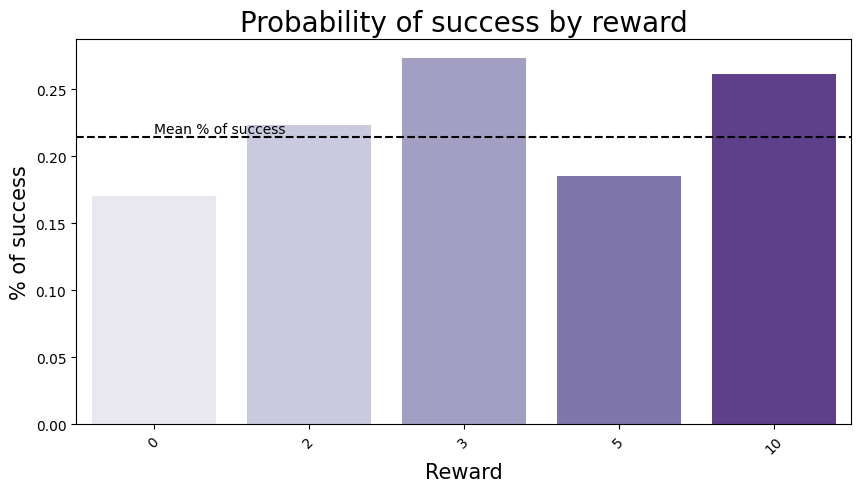

In [47]:
plot_successful_projects_probabilities(df=df_analysis, attribute='reward', attribute_title='reward', palette='Purples')

In relation to the previous graph, offers that provide a reward of $3 are the most successful because they only require a $7 spend, making the balance between cost and reward attractive to customers. Offers that give a reward of $10 are the "Buy One Get One Free" offers, which are the second most successful. Lastly, offers that give a reward of $0 are the "Informational" types, essentially just advertisements, which explains why they have the lowest success rate as anticipated.

In [48]:
def income_interval(income):
    """
    Categorize income into an interval.

    Parameters:
    income (float): The income to be categorized.

    Returns:
    str: The interval in which the income falls.

    Raises:
    ValueError: If the income is not within the expected range.

    This function takes an income value as input, converts it to thousands, and returns the corresponding income interval as a string.
    """
    income = income / 1000
    if 30 <= income < 40:
        interval = '[30, 40)'
    elif 40 <= income < 50:
        interval = '[40, 50)'
    elif 50 <= income < 60:
        interval = '[50, 60)'
    elif 60 <= income < 70:
        interval = '[60, 70)'
    elif 70 <= income < 80:
        interval = '[70, 80)'
    elif 80 <= income < 90:
        interval = '[80, 90)'
    elif 90 <= income < 100:
        interval = '[90, 100)'
    elif income >= 100:
        interval = '[100+, ]'
    else:
        raise ValueError(f"Unknown value for income: {income}")
    return interval

In [49]:
df_analysis['income_interval'] = df_analysis['income'].apply(income_interval)

/tmp/ipykernel_1201868/1644501313.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p1 = sns.barplot(x=attribute, y='% of success', data=df_plot, palette=palette)


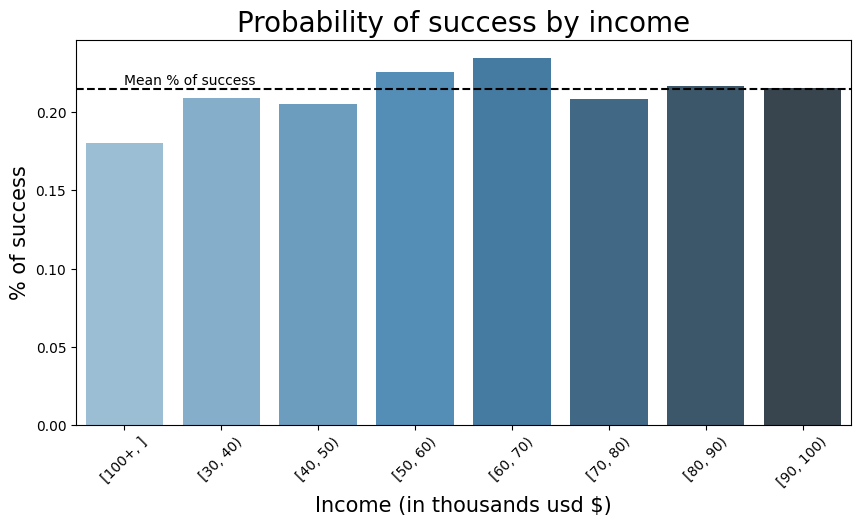

In [50]:
plot_successful_projects_probabilities(df=df_analysis, attribute='income_interval', attribute_title='income', x_axis_title='income (in thousands USD $)', palette='Blues_d')

An interesting finding from the graph is that customers with incomes of $100K USD or more are the least influenced by offers. Presumably, these customers, having substantial financial resources, are not swayed by discounts and would purchase their Starbucks items regardless of the circumstances. It might be a good strategy to either not send them offers or do so less frequently compared to other population groups. The most influenced customers have incomes between $60K and $70K USD per year, with the next most influenced group earning between $50K and $60K USD annually.

# 4. Machine Learning

In [51]:
random_state = 42
np.random.seed(random_state)

X = final_df.drop(['successful_offer'], axis=1)
y = final_df['successful_offer'].astype(int)

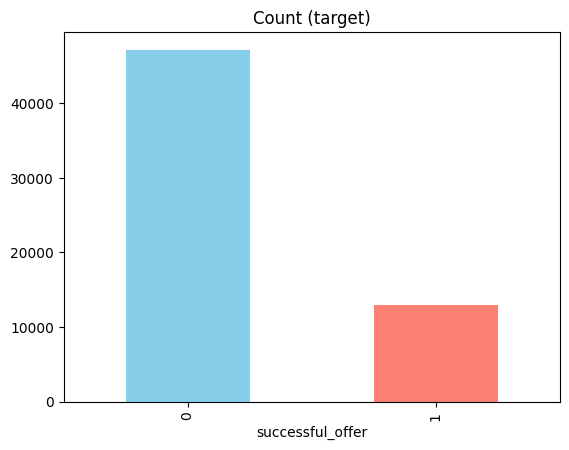

In [52]:
# Define a list of colors for each bar
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightpink']

# Plot the bar chart with different colors for each bar
y.value_counts().plot(kind='bar', title='Count (target)', color=colors)

# Show the plot
plt.show()

In [53]:
# Initialize the RandomOverSampler
ros = RandomOverSampler()

# Apply the RandomOverSampler to the feature matrix X and target vector y
X_ros, y_ros = ros.fit_resample(X, y)

# Print the number of new randomly picked points added to balance the dataset
print(X_ros.shape[0] - X.shape[0], 'new random picked points')

34155 new random picked points


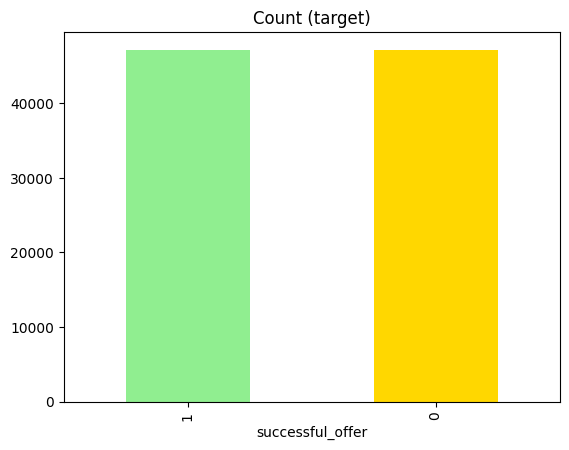

In [54]:
pd.Series(y_ros).value_counts().plot(kind='bar', title='Count (target)',  color=colors[2:]);

## 4.1 Metrics

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.20, random_state=random_state)

In [56]:
def train_and_test_model(model, X_train, X_test, y_train, y_test, print_time=True):
    """
    Train and test a machine learning model.

    Parameters:
    model: The machine learning model to be trained and tested.
    X_train (DataFrame or array-like): The training feature data.
    X_test (DataFrame or array-like): The testing feature data.
    y_train (Series or array-like): The training target data.
    y_test (Series or array-like): The testing target data.
    print_time (bool, optional): Whether to print the training time. Defaults to True.

    Returns:
    model: The trained machine learning model.

    This function trains the provided model on the training data and evaluates it on both the training and testing data.
    It displays the accuracy, recall, and precision metrics for both the training and testing datasets in a table format.
    """

    # Record the start time
    start = time.time()
    
    # Train the model
    model = model.fit(X_train, y_train)
    
    # Record the end time
    end = time.time()
    
    # Optionally print the training time
    if print_time:
        print(f'The model took {end - start:.2f} seconds to train.')
    
    # Make predictions on the training and testing data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Calculate accuracy, recall, and precision metrics
    metrics = {
        'Metric': ['Accuracy', 'Recall', 'Precision'],
        'Train': [
            accuracy_score(y_train, train_predictions),
            recall_score(y_train, train_predictions),
            precision_score(y_train, train_predictions)
        ],
        'Test': [
            accuracy_score(y_test, test_predictions),
            recall_score(y_test, test_predictions),
            precision_score(y_test, test_predictions)
        ]
    }
    
    # Create a DataFrame to display the metrics
    metrics_df = pd.DataFrame(metrics)
    
    # Display the metrics in a table format
    display(metrics_df)
    
    return model

### 4.1.0 Dummy Model

In [56]:
dummy = DummyClassifier(strategy='constant', constant=0)
train_and_test_model(dummy, X_train, X_test, y_train, y_test, print_time=False);

/home/britzj03/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/britzj03/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Train,Test
0,Accuracy,0.498754,0.504982
1,Recall,0.000000,0.000000
2,Precision,0.000000,0.000000


### 4.1.1 Logistic Regression

In [57]:
lr = LogisticRegression(random_state=random_state, solver='liblinear');
train_and_test_model(lr, X_train, X_test, y_train, y_test);

The model took 1.46 seconds to train.


,Metric,Train,Test
0,Accuracy,0.591493,0.588510
1,Recall,0.699622,0.699036
2,Precision,0.576187,0.568629


### 4.1.2 Decision Tree

In [58]:
dt = DecisionTreeClassifier(random_state=random_state);
train_and_test_model(dt, X_train, X_test, y_train, y_test);

The model took 0.49 seconds to train.


,Metric,Train,Test
0,Accuracy,0.941155,0.779468
1,Recall,0.982289,0.897966
2,Precision,0.907867,0.723329


### 4.1.3 Random Forest

In [59]:
rf = RandomForestClassifier(random_state=random_state, n_estimators=100);
train_and_test_model(rf, X_train, X_test, y_train, y_test);

The model took 12.96 seconds to train.


,Metric,Train,Test
0,Accuracy,0.941142,0.816038
1,Recall,0.988686,0.918201
2,Precision,0.903079,0.760082


### 4.1.4 Gradient Boosting

In [60]:
gbc = GradientBoostingClassifier(random_state=random_state);
train_and_test_model(gbc, X_train, X_test, y_train, y_test);

The model took 12.39 seconds to train.


,Metric,Train,Test
0,Accuracy,0.600769,0.598368
1,Recall,0.698115,0.695503
2,Precision,0.585319,0.578451


### 4.1.5 Adaboost

In [61]:
adc = AdaBoostClassifier(random_state=random_state);
train_and_test_model(adc, X_train, X_test, y_train, y_test);

The model took 3.33 seconds to train.


,Metric,Train,Test
0,Accuracy,0.590261,0.586602
1,Recall,0.674192,0.672591
2,Precision,0.578296,0.569848


### 4.1.6 XGBoost

In [62]:
xg = XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1
)
train_and_test_model(xg, X_train, X_test, y_train, y_test);

The model took 239.16 seconds to train.


,Metric,Train,Test
0,Accuracy,0.636531,0.616335
1,Recall,0.729255,0.706959
2,Precision,0.616111,0.594597


As observed, the Random Forest Classifier is the top-performing model. However, it exhibits overfitting, with a training accuracy of around 94% and a testing accuracy of approximately 81%. To address this, we will perform hyperparameter tuning to improve the model.

In this particular problem, we prioritize recall over precision. We believe it is better to send offers to all clients who might be influenced by them, even if it means also sending offers to clients who will not respond positively. Over time, this strategy should increase revenues more than it increases the costs associated with additional offers. Notably, the Random Forest Classifier also had the best recall metric.

## 4.2 Hyper Parameter Tuning

In [63]:
parameters = {
    'n_estimators': [100, 300],  # Number of trees in the forest
    'criterion': ['gini'],  # Function to measure the quality of a split
    'max_depth': [None, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'min_weight_fraction_leaf': [0.0],  # Minimum weighted fraction of the sum total of weights required to be at a leaf node
    'max_features': ['log2', 'sqrt'],  # Number of features to consider when looking for the best split
    'max_leaf_nodes': [None],  # Unlimited number of leaf nodes
    'min_impurity_decrease': [0.0],  # Minimum decrease in impurity required for a split
    'bootstrap': [True],  # Whether bootstrap samples are used when building trees
    'oob_score': [False],  # Whether to use out-of-bag samples to estimate the generalization accuracy
    'n_jobs': [None],  # Number of jobs to run in parallel
    'random_state': [random_state],  # Random state for reproducibility
    'verbose': [0],  # Controls the verbosity when fitting and predicting
    'warm_start': [False],  # Reuse the solution of the previous call to fit and add more estimators to the ensemble
    'class_weight': [None],  # Weights associated with classes
    'ccp_alpha': [0.0],  # Complexity parameter used for Minimal Cost-Complexity Pruning
    'max_samples': [None]  # Number of samples to draw from X to train each base estimator
}

grid_object = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc')
grid_object = train_and_test_model(grid_object, X_train, X_test, y_train, y_test, print_time=False);

,Metric,Train,Test
0,Accuracy,0.941155,0.816780
1,Recall,0.987708,0.914882
2,Precision,0.903822,0.762470


In [64]:
best_model = grid_object.best_estimator_
best_model

RandomForestClassifier(max_features='log2', n_estimators=300, random_state=42)

In [65]:
feature_importances = best_model.feature_importances_

In [66]:
def feature_plot(importances, X, y_train, n_features):
    """
    Display the "n_features" most important features.

    This function creates a bar plot to visualize the importance of the top "n_features" features
    based on their normalized weights. It also includes a cumulative feature weight bar to show
    the cumulative importance of the features.

    Args:
        importances (array-like): The feature importances from the model.
        X (pd.DataFrame): The input features DataFrame.
        y_train (pd.Series): The target variable for training.
        n_features (int): The number of top features to display.

    Returns:
        None
    """
    # Get the indices of the top n_features sorted by importance in descending order
    indices = np.argsort(importances)[::-1]
    
    # Get the column names of the top n_features
    columns = X.columns.values[indices[:n_features]]
    
    # Get the importance values of the top n_features
    values = importances[indices][:n_features]

    # Create a figure for the plot
    fig = plt.figure(figsize=(9, 7))
    
    # Set the title of the plot
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize=16)
    
    # Plot the feature weights
    plt.bar(np.arange(n_features), values, width=0.6, align="center", color='#00A000', label="Feature Weight")
    
    # Plot the cumulative feature weights
    plt.bar(np.arange(n_features) - 0.3, np.cumsum(values), width=0.2, align="center", color='#00A0A0',
            label="Cumulative Feature Weight")
    
    # Set the x-ticks with the feature names and rotate them for better readability
    plt.xticks(np.arange(n_features), columns, rotation=45)
    
    # Set the x-axis limits
    plt.xlim((-0.5, n_features - 0.5))
    
    # Set the y-axis label
    plt.ylabel("Weight", fontsize=12)
    
    # Set the x-axis label
    plt.xlabel("Feature", fontsize=12)

    # Add a legend to the plot
    plt.legend(loc='upper left')
    
    # Adjust the layout to fit everything nicely
    plt.tight_layout()
    
    # Display the plot
    plt.show()

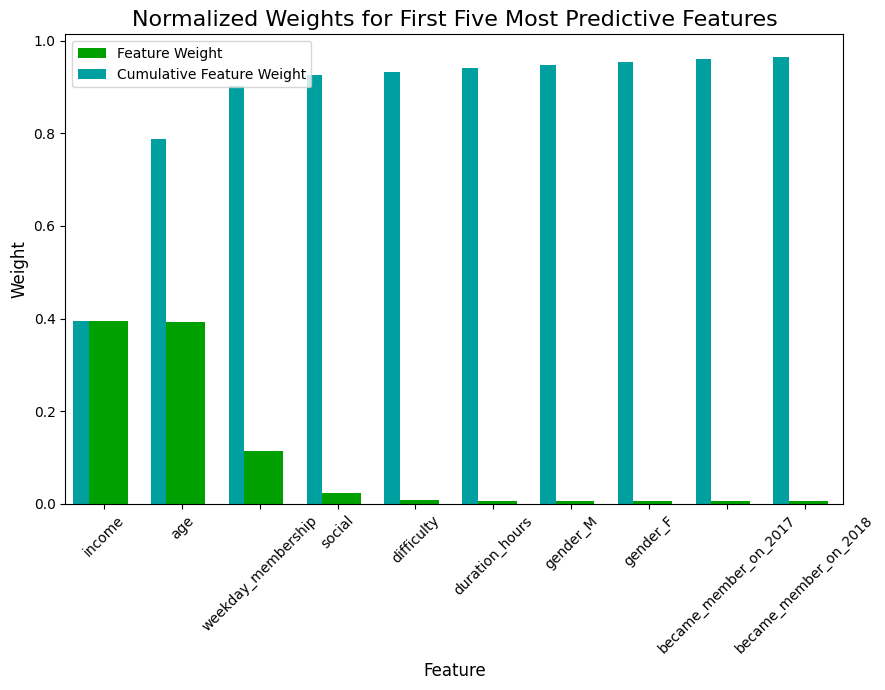

In [68]:
feature_plot(feature_importances, X, y_train, 10)

In [69]:
def save_model(model, model_filepath):
    """
    Save the model as a pickle file.

    This function saves the given model to the specified file path using the pickle module.
    The model is serialized and stored in binary format.

    Args:
        model (object): The model to be saved.
        model_filepath (str): The file path where the model will be saved.

    Returns:
        None
    """
    with open(model_filepath, 'wb') as pickle_model:
        pickle.dump(model, pickle_model)

In [70]:
save_model(best_model, 'models/random_forest_classifier.pkl')

In [57]:
def load_model(model_filepath):
    """
    Load a trained machine learning model.

    This function loads a model from the specified file path using the pickle module.
    The model is deserialized from the binary format and returned.

    Args:
        model_filepath (str): The file path from which the model will be loaded.

    Returns:
        object: The loaded model.
    """
    with open(model_filepath, 'rb') as pickle_model:
        model = pickle.load(pickle_model)
    return model

In [58]:
model = load_model('models/random_forest_classifier.pkl')

In [59]:
X_test.iloc[0].values.reshape(-1, 1).T.shape

(1, 22)

In [60]:
model.predict(X_test.iloc[0].values.reshape(1, -1))

/home/britzj03/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1])

In [77]:
y_test.iloc[0]

1

In [78]:
X.columns

Index(['age', 'income', 'weekday_membership', 'gender_F', 'gender_M',
       'gender_O', 'became_member_on_2013', 'became_member_on_2014',
       'became_member_on_2015', 'became_member_on_2016',
       'became_member_on_2017', 'became_member_on_2018', 'reward',
       'difficulty', 'email', 'mobile', 'social', 'web', 'duration_hours',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational'],
      dtype='object')

In [79]:
df_analysis[(df_analysis['offer_id'] == 'ae264e3637204a6fb9bb56bc8210ddfd') & (df_analysis['id'] == '00fbb9b5edb94f02afbaf1eb49bb4d7d')]

,offer_id,age,id,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,...,offer_type_discount,offer_type_informational,successful_offer,reward,channels,difficulty,duration,offer_type,age_interval,income_interval
48526,ae264e3637204a6fb9bb56bc8210ddfd,56,00fbb9b5edb94f02afbaf1eb49bb4d7d,91000.0,4,1,0,0,0,0,...,0.0,0.0,0.0,10,"[email, mobile, social]",10,7,bogo,"[50, 60)","[90, 100)"


In [80]:
portfolio_after_engineer[portfolio_after_engineer['offer_id'] == 'ae264e3637204a6fb9bb56bc8210ddfd'].drop('offer_id', axis=1).values

array([[ 10,  10,   1,   1,   1,   0, 168,   1,   0,   0]])

In [81]:
profile_after_engineered[profile_after_engineered['id'] == '00fbb9b5edb94f02afbaf1eb49bb4d7d']

,age,id,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
14591,56,00fbb9b5edb94f02afbaf1eb49bb4d7d,91000.0,4,1,0,0,0,0,0,0,0,1


In [61]:
def get_offer_user_attributes(portfolio_after_engineer, profile_after_engineered, offer_id, user_id):
    """
    Get the offer and user attributes from DataFrames.

    This function retrieves the attributes of a specified offer and user from the engineered portfolio
    and profile DataFrames. It ensures that the provided offer ID and user ID exist in the respective
    DataFrames and then combines their attributes into a single array.

    Args:
        portfolio_after_engineer (pd.DataFrame): The engineered portfolio DataFrame.
        profile_after_engineered (pd.DataFrame): The engineered profile DataFrame.
        offer_id (str): The ID of the offer to retrieve attributes for.
        user_id (str): The ID of the user to retrieve attributes for.

    Returns:
        np.ndarray: An array containing the combined attributes of the specified offer and user.
    """
    assert offer_id in list(portfolio_after_engineer['offer_id']), f"Offer ID {offer_id} not found in portfolio DataFrame."
    assert user_id in list(profile_after_engineered['id']), f"User ID {user_id} not found in profile DataFrame."

    offer_values_dict = portfolio_after_engineer[portfolio_after_engineer['offer_id'] == offer_id].drop('offer_id',
                                                                                                axis=1).to_dict(
        'records')[0]
    user_values_dict = profile_after_engineered[profile_after_engineered['id'] == user_id].drop('id', axis=1).to_dict('records')[0]

    return offer_values_dict, user_values_dict

In [62]:
values = get_offer_user_attributes(portfolio_after_engineer, profile_after_engineered, 'ae264e3637204a6fb9bb56bc8210ddfd', '00fbb9b5edb94f02afbaf1eb49bb4d7d')

In [63]:
values.reshape(-1, 1)

AttributeError: 'tuple' object has no attribute 'reshape'

In [67]:
def predict(model, portfolio_after_engineering, profile_after_engineering, offer_id, user_id):
    """
    Make a prediction using a machine learning model.

    This function takes a trained machine learning model, engineered DataFrames for portfolio and profile,
    and specific offer and user IDs. It retrieves the corresponding attributes, combines them, and returns
    the model's prediction.

    Args:
        model (object): The trained machine learning model.
        portfolio_after_engineering (pd.DataFrame): The engineered DataFrame containing offer data.
        profile_after_engineering (pd.DataFrame): The engineered DataFrame containing user profile data.
        offer_id (str): The ID of the offer to retrieve attributes for.
        user_id (str): The ID of the user to retrieve attributes for.

    Returns:
        The prediction result from the model.
    """
    # Get the offer and user attributes
    offer_values_dict, user_values_dict = get_offer_user_attributes(portfolio_after_engineering, profile_after_engineering, offer_id, user_id)
    
    # Combine the offer and user attributes into a single array
    combined_values = list(offer_values_dict.values()) + list(user_values_dict.values())
    
    # Convert the combined values to a numpy array
    combined_values_array = np.array(combined_values).reshape(1, -1)
    
    # Make the prediction
    prediction = model.predict(combined_values_array)
    
    return prediction

In [68]:
predict(model, portfolio_after_engineer, profile_after_engineered, 'ae264e3637204a6fb9bb56bc8210ddfd', '00fbb9b5edb94f02afbaf1eb49bb4d7d')

/home/britzj03/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0])